In [1]:
import numpy as np
import matplotlib.pyplot as plt

Logistic regression

Estimated parameters: [-6.94221918e+00  2.02791214e+04 -2.02599617e+04]


/var/folders/r5/sn6df7m50hg3bf0tzsxzg33m0000gn/T/ipykernel_3061/4126112062.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


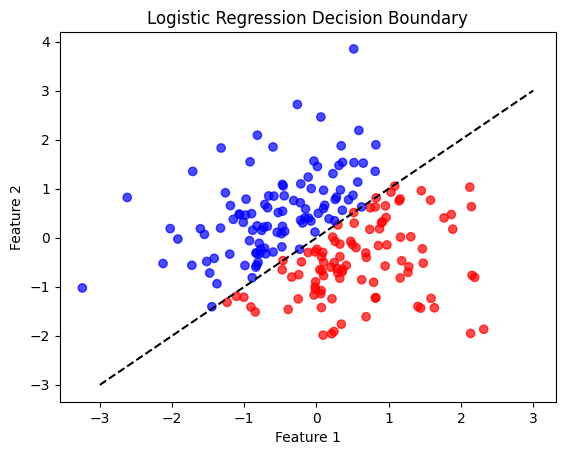

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def nll(w, X, y):
    z = X.dot(w)
    p = sigmoid(z)
    eps = 1e-15  # To avoid log(0)
    return -np.sum(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))

np.random.seed(42)
n_samples = 200
X = np.random.randn(n_samples, 2)
true_w = np.array([1.0, -1.0])
y_prob = sigmoid(X.dot(true_w))
y = (y_prob > 0.5).astype(float)

X_design = np.c_[np.ones(n_samples), X]
initial_w = np.zeros(X_design.shape[1])

from scipy.optimize import minimize
result = minimize(nll, initial_w, args=(X_design, y), method='BFGS')
w_hat = result.x
print("Estimated parameters:", w_hat)

# Plotting decision boundary
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
x1 = np.linspace(-3, 3, 100)
x2 = -(w_hat[0] + w_hat[1] * x1) / w_hat[2]
plt.plot(x1, x2, 'k--')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.show()

Support Vector Machines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

In [2]:
import numpy as np
from cvxopt import matrix, solvers

class LinearSVM:
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = y.astype(float)

        # Compute the Gram matrix
        K = X @ X.T

        # Setup parameters for QP solver
        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        G_std = np.diag(-np.ones(n_samples))
        h_std = np.zeros(n_samples)
        G_slack = np.diag(np.ones(n_samples))
        h_slack = np.ones(n_samples) * self.C
        G = matrix(np.vstack((G_std, G_slack)))
        h = matrix(np.hstack((h_std, h_slack)))
        A = matrix(y, (1, n_samples), 'd')
        b = matrix(0.0)

        # Solve QP
        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.sv_X = X[sv]
        self.sv_y = y[sv]

        # Compute weight vector
        self.w = np.sum(self.alphas[:, None] * self.sv_y[:, None] * self.sv_X, axis=0)

        # Compute bias
        self.b = np.mean(self.sv_y - self.sv_X @ self.w)

    def project(self, X):
        return X @ self.w + self.b

    def predict(self, X):
        return np.sign(self.project(X))


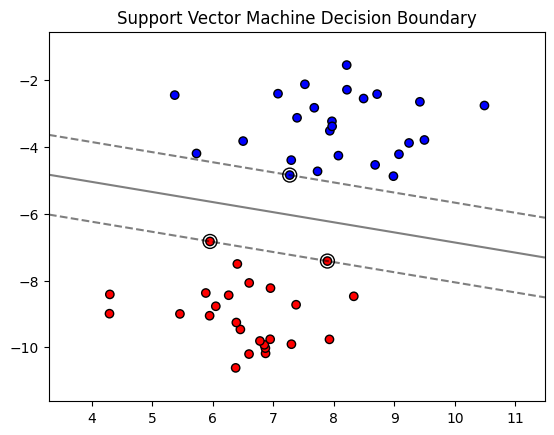

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate data
X, y = make_blobs(n_samples=50, centers=2, random_state=6)
y = 2*y - 1  # convert to {-1, 1}

# Train SVM
svm = LinearSVM(C=1.0)
svm.fit(X, y)

# Plot decision boundary
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
ax = plt.gca()

# Plot separating hyperplane
xx = np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 50)
yy = np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 50)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svm.project(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1],
           alpha=0.5, linestyles=['--', '-', '--'])

# Highlight support vectors
plt.title('Support Vector Machine Decision Boundary')
plt.scatter(svm.sv_X[:, 0], svm.sv_X[:, 1], s=100,
            facecolors='none', edgecolors='k')
plt.show()


The difference between logistic regression and SVM is that logistic regression minimize the negative log-likelihood to do classfication, SVM maximize the margin between the closest point by determining weights and bias.

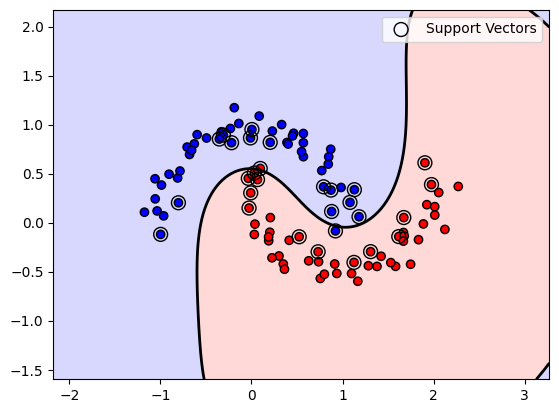

In [ ]:
### Kernel SVM can be implemented by replacing the dot product with a kernel function.

def rbf_kernel(x1, x2, gamma):

    ### First compute the squared Euclidean distances
    ### Then apply the RBF formula
    sq_dists = np.sum(x1**2, axis-1).reshape(-1, 1) + np.sum(x2**2, axis-1) - 2 * np.dot(x1, x2.T)
    return np.exp(-gamma * sq_dists)

### Make some data
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC

X, y = make_moons(n_samples=100, noise=0.1, random_state=42)

clf = SVC(kernel='rbf', gamma=1.0, C=1.0)
clf.fit(X, y)

xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 500),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z > 0, alpha=0.3, cmap='bwr')
plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolors='k')
plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], s=100,
            facecolors='none', edgecolors='k', label='Support Vectors')
plt.legend()
plt.show()

K-nearest neighbors

In [7]:
import numpy
from sklearn.datasets import make_blobs

Accuracy: 0.38


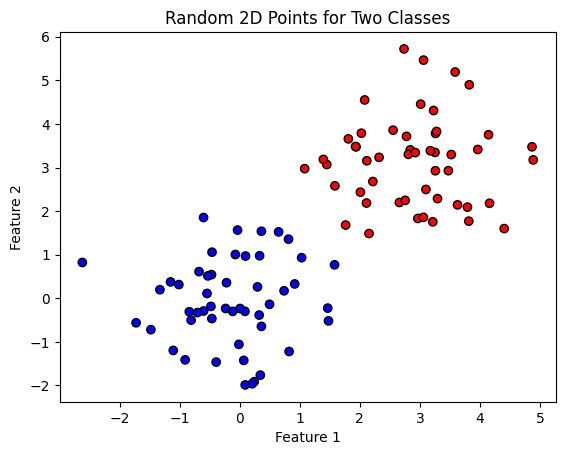

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate 50 points for class 0 centered at (0, 0)
X0 = np.random.randn(50, 2) + np.array([0, 0])
y0 = np.zeros(50)

# Generate 50 points for class 1 centered at (3, 3)
X1 = np.random.randn(50, 2) + np.array([3, 3])
y1 = np.ones(50)

# Combine the data
X = np.vstack((X0, X1))
y = np.hstack((y0, y1))

accuracy = np.mean(y_pred == y)
print("Accuracy:", accuracy)
# Plot the points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Random 2D Points for Two Classes')
plt.show()

Accuracy: 1.0
Gini impurity of the root node: 0.5


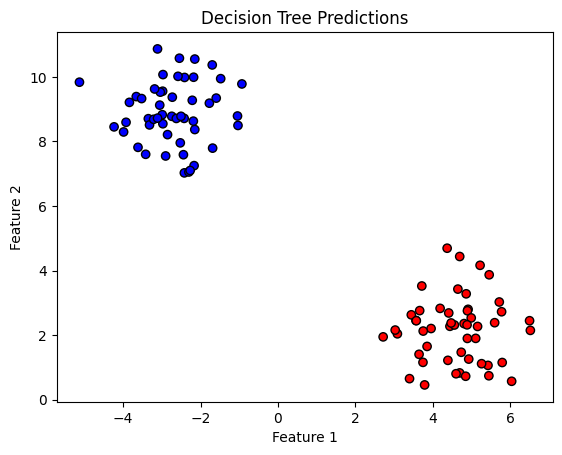

In [19]:
np.random.seed(42)
### Data generation
X, y = make_blobs(n_samples=100, centers=2, random_state=42)

### Measure how mix the classes are
### Gini = 0 -> pure (All one class)
### Gini = 0.5 -> mixed (Half and half)
def Gini(y):
    m = len(y)
    if m == 0:
        return 0
    p = np.sum(y) / m
    return 1 - p**2 - (1 - p)**2

def Best_split(X, y):
    m, n = X.shape
    best_gini = float('inf')
    best_idx, best_thr = None, None
    for idx in range(n): ### loop over features
        thresholds = np.unique(X[:, idx]) ### unique values as thresholds
        for thr in thresholds: ### loop over thresholds
            left_mask = X[:, idx] < thr ### left split
            right_mask = X[:, idx] >= thr ### right split

            ### Compute Gini impurity for the split
            gini_left = Gini(y[left_mask]) ### Gini of left split 
            gini_right = Gini(y[right_mask]) ### Gini of right split
            gini = (np.sum(left_mask) * gini_left + np.sum(right_mask) * gini_right) / m ### weighted Gini

            ### Evaluate the split
            if gini < best_gini:
                best_gini = gini
                best_idx, best_thr = idx, thr
            
    ### Return the best feature index and threshold
    return best_idx, best_thr


def build_tree(X, y, depth=0, max_depth=5):
    m, n = X.shape
    num_pos = np.sum(y)
    num_neg = m - num_pos
    if m == 0 or depth == max_depth or num_pos == 0 or num_neg == 0:
        return 1 if num_pos >= num_neg else 0
    idx, thr = Best_split(X, y)
    if idx is None:
        return 1 if num_pos >= num_neg else 0
    left_mask = X[:, idx] < thr
    right_mask = X[:, idx] >= thr
    left_subtree = build_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
    right_subtree = build_tree(X[right_mask], y[right_mask], depth + 1, max_depth)
    return (idx, thr, left_subtree, right_subtree)

def predict_tree(tree, x):
    if isinstance(tree, int):
        return tree
    idx, thr, left_subtree, right_subtree = tree
    if x[idx] < thr:
        return predict_tree(left_subtree, x)
    else:
        return predict_tree(right_subtree, x)

tree = build_tree(X, y, max_depth=5)
y_pred = np.array([predict_tree(tree, x) for x in X])
accuracy = np.mean(y_pred == y)
print("Accuracy:", accuracy)
print("Gini impurity of the root node:", Gini(y))

plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='bwr', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Tree Predictions')
plt.show()